## T2 Experiment using QProgram

In [6]:
import numpy as np
import qililab as ql

from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

from qililab.utils import from_dict

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit


api = API(ConnectionConfiguration(username="qat", api_key="meow"))


api.select_device_id(9)
ql.logger.setLevel(40)  # Set qililab's logger to a higher level so it only shows error messages

In [10]:
# Qubit to run the experiment on

QUBIT = 4

### Gates definition

In [14]:
runcard = api.get_runcard(runcard_name="galadriel_qprogram")
runcard_as_dict = runcard.runcard

RO_duration_runcard = runcard_as_dict["gates_settings"]["gates"][f"M({QUBIT})"][0]["pulse"]["duration"]
RO_amplitude_runcard = runcard_as_dict["gates_settings"]["gates"][f"M({QUBIT})"][0]["pulse"]["amplitude"]
X_duration_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["duration"]
X_num_sigmas_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["shape"]["num_sigmas"]
X_drag_coefficient_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["shape"][
    "drag_coefficient"
]
X_amplitude_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["amplitude"]

In [4]:
print(
    "drag params:\n \t amplitude",
    X_amplitude_runcard,
    "    duration",
    X_duration_runcard,
    "    drag coeff",
    X_drag_coefficient_runcard,
    "    sigmas",
    X_num_sigmas_runcard,
)
print("RO params:\n \t amplitude", RO_amplitude_runcard, "\t           duration", RO_duration_runcard)

drag params:
 	 amplitude 0.24641175677808694     duration 40     drag coeff -0.5069253980288412     sigmas 4
RO params:
 	 amplitude 0.111 	           duration 1700


### Experiment settings

In [15]:
shots = 14000

wait_start = 0
wait_stop = 40_000
wait_step = 1000


control_wf = ql.IQPair.DRAG(
    amplitude=0.5 * X_amplitude_runcard,  ## because it's a pi/2 pulse
    duration=X_duration_runcard,
    num_sigmas=X_num_sigmas_runcard,
    drag_coefficient=X_drag_coefficient_runcard,
)
readout_wf = ql.IQPair(
    I=ql.Square(amplitude=1.0 * RO_amplitude_runcard, duration=RO_duration_runcard),
    Q=ql.Square(amplitude=0.0 * RO_amplitude_runcard, duration=RO_duration_runcard),
)

time_of_flight = (
    200  ## approximate time it takes for the pulse to reach the set-up, before that we'll just measure noise.
)

acquisition_weights_duration = RO_duration_runcard
acquisition_weights = ql.IQPair(
    I=ql.Square(amplitude=1.0, duration=acquisition_weights_duration),
    Q=ql.Square(amplitude=1.0, duration=acquisition_weights_duration),
)

qubit_relaxation_duration = 200_000

### QProgram definition

In [16]:
qp = ql.QProgram(disable_autosync=True)
wait_variable = qp.variable(ql.Domain.Time)
with qp.average(shots=shots):
    with qp.for_loop(variable=wait_variable, start=wait_start, stop=wait_stop, step=wait_step):
        qp.play(bus=f"drive_q{QUBIT}_bus", waveform=control_wf)  ## apply Xpi/2 gate
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=wait_variable)  # wait
        qp.play(bus=f"drive_q{QUBIT}_bus", waveform=control_wf)  ## apply Xpi/2 gate
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=time_of_flight)  # wait for the RO pulse to get to the fridge
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=acquisition_weights.get_duration())  ## wait for data acquisition
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=qubit_relaxation_duration)  ## wait for qubit reinitialisation

        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=control_wf.get_duration())  ## wait for first Xpi/2 pulse
        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=wait_variable)  ## wait for wait time
        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=control_wf.get_duration())  ## wait second for Xpi/2 pulse
        qp.play(bus=f"readout_q{QUBIT}_bus", waveform=readout_wf, wait_time=time_of_flight)  ## send readout pulse
        qp.acquire(bus=f"readout_q{QUBIT}_bus", weights=acquisition_weights)  ## acquire data
        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=qubit_relaxation_duration)  ## wait for qubit reinitialisation

full_qprogram = qp.to_dict()

### Experiment execution

In [17]:
result_id = api.execute(
    qprogram=full_qprogram,
    name="t2*",
    summary=f"timeofflight{time_of_flight}_waitstop{wait_stop}_waitstep{wait_step}_shots{shots}",
)[0]
print(result_id)

9709


In [7]:
results = api.get_result(result_id)

Your job with id 9709 is completed.


###  De-serialising results and post-processing

In [8]:
qprogram_results = from_dict(results)

In [11]:
i_vec, q_vec = qprogram_results.results[f"readout_q{QUBIT}_bus"][0].array  ## i, q
s21_vec = 20 * np.log10(np.sqrt(i_vec**2 + q_vec**2))

###  Plotting

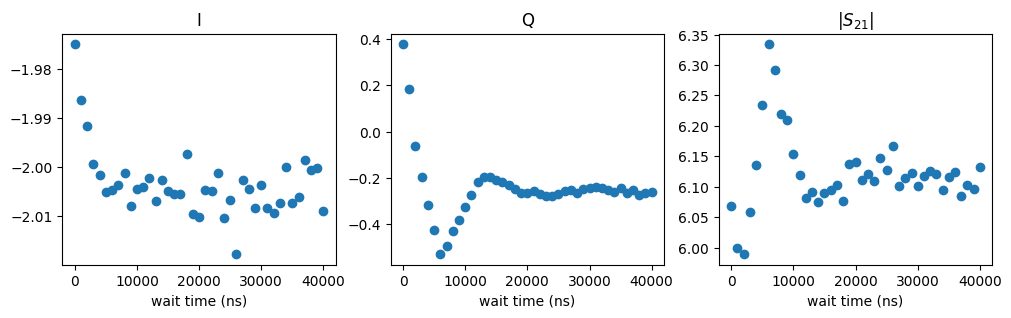

In [16]:
xaxis = np.arange(wait_start, wait_stop + wait_step, wait_step)
data = [i_vec, q_vec, s21_vec]
titles = ["I", "Q", "$|S_{21}|$"]
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.plot(xaxis, data[i], "o")
    ax.set_xlabel("wait time (ns)")
    ax.set_title(titles[i])

Since points landed along the Q axis in this measurement, we will use this variable for the fit

Optimized Parameters: [ 6.04608665e-01  6.58286784e+03 -2.64284463e-01  1.23293026e+00]


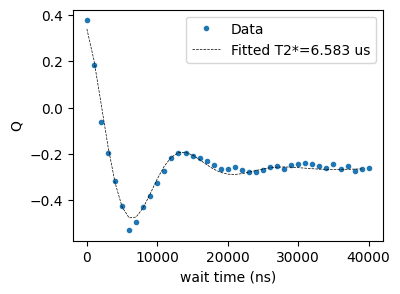

In [49]:
# Define the decaying exponential function
def damped_cosine(x, A, T2, C, detuning):
    return A * np.cos(2 * np.pi * detuning * x) * np.exp(-1 / T2 * x) + C


xaxis = np.arange(wait_start, wait_stop + wait_step, wait_step)
fit_up2 = -1  # 20
# Generate some sample data
x_data = xaxis[:fit_up2]
y_data = q_vec[:fit_up2]

# Fit the decaying exponential function to the data
initial_guess = [0.5, 2_000, 0, 0]  # initial guess for the parameters A, T2, C, detuning
optimized_params, _ = curve_fit(damped_cosine, x_data, y_data, p0=initial_guess)

# Print the optimized parameters
print("Optimized Parameters:", optimized_params)

# Plot the data and the fitted function
plt.figure(figsize=(4, 3))
plt.plot(xaxis, q_vec, "o", ms=3, label="Data")
plt.plot(
    x_data,
    damped_cosine(x_data, *optimized_params),
    "k--",
    lw=0.5,
    label=f"Fitted T2*={optimized_params[1]/1000:.3f} us",
)
plt.legend()
plt.xlabel("wait time (ns)")
plt.ylabel("Q")
plt.show()
T2_fit_ns = optimized_params[1]